In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import copy
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import json
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_rows', None)
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\happy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\happy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# 시드 고정
import os

SEED=42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

In [3]:
train = pd.read_csv("train.csv") # 학습용 데이터
test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [4]:
# 학습 타겟 데이터
targets=train['is_converted']
rows=train.shape[0]

with open('permitted.json','r') as f:
    permitted=json.load(f)

# 
train=train.drop('is_converted',axis=1)
test=test.drop('id',axis=1)
test=test.drop('is_converted',axis=1)

In [5]:
# columns
cols_by_type={}

cols_by_type['categorical']=train.columns[train.dtypes=='object'].tolist()
cols_by_type['numerical']=train.columns[train.dtypes!='object'].tolist()
#colsByType['numerical'].remove('is_converted')

print('\nnumerical columns: '+str(len(cols_by_type['numerical'])))
print('categorical columns: '+str(len(cols_by_type['categorical'])))
print('total columns: '+str(len(cols_by_type['numerical'])+len(cols_by_type['categorical'])))


numerical columns: 13
categorical columns: 15
total columns: 28


In [6]:
# delete cols
del_cols=['ver_win_rate_x','ver_win_ratio_per_bu',
          'business_subarea', 'product_subcategory', 'product_modelname', 
          'customer_country.1']

# preserve
# preserve=pd.DataFrame()
# preserve['com_reg_ver_win_rate']=total_data['com_reg_ver_win_rate']

train_process=train.drop(del_cols,axis=1)
test_process=test.drop(del_cols,axis=1)

In [7]:
# id_strategic_ver it_strategic_ver idit_strategic_ver
ver=['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver']
train_process['strategic_ver']=np.where(train_process['idit_strategic_ver']>0,1,0)
test_process['strategic_ver']=np.where(test_process['idit_strategic_ver']>0,1,0)
train_process=train_process.drop(ver,axis=1)
test_process=test_process.drop(ver,axis=1)

In [8]:
# country columns
# region
def preprocess_region(x,permitted):
    if type(x)==type(''):
        if permitted.get(x):
            return permitted[x]
        return 'OT'
    return np.nan

def response_corporate_encoding(train_data):
    permit={}
    
    for train_label in train_data.value_counts().index:
        permit[train_label]=1
    permit['OT']=1

    return permit

def preprocess_response_corporate(x,permitted):
    if type(x)==type(''):
        if permitted.get(x):
            return x
        return 'OT'
    return np.nan


def country_encoding(train_data):
    permit={}

    train_labels=train_data.apply(lambda x:x.lower().replace(' ','').replace('/',' ').split(' ')[-1] if type(x)==type('') else np.nan).value_counts()
    train_labels=sorted(train_labels.items(),key=lambda x:x[1],reverse=True)

    for train_label in train_labels[:100]:
        if train_label[0]:
            permit[f'{train_label[0]}']=1
    
    if permit.get(''):
        del permit['']
    
    # 
    permit['OT']='OT'
    permit['dump_key']='dump_value'
    permit['türkiye']='turkey'
    del permit['700patrooncreekblvdalbanyny12206']
    del permit['uaedubai']
    
    return permit

def preprocess_customer_country(x,permitted):
    if type(x)==type(''):
        x=x.lower().replace(' ','').replace('/',' ')
        for word in x.split(' '):
            if permitted.get(word):
                return word
        return 'OT'
    return np.nan

# region
train_process['region']=train_process['response_corporate'].apply(lambda x:preprocess_region(x,permitted=permitted['region']))
test_process['region']=test_process['response_corporate'].apply(lambda x:preprocess_region(x,permitted=permitted['region']))

# response_corporate
permitted['response_corporate']=response_corporate_encoding(train['response_corporate'])
train_process['response_corporate']=train_process['response_corporate'].apply(lambda x:preprocess_response_corporate(x,permitted=permitted['response_corporate']))
test_process['response_corporate']=test_process['response_corporate'].apply(lambda x:preprocess_response_corporate(x,permitted=permitted['response_corporate']))

# customer_country   
permitted['customer_country']=country_encoding(train['customer_country'])
train_process['customer_country']=train_process['customer_country'].apply(lambda x:preprocess_customer_country(x,permitted=permitted['customer_country']))
test_process['customer_country']=test_process['customer_country'].apply(lambda x:preprocess_customer_country(x,permitted=permitted['customer_country']))

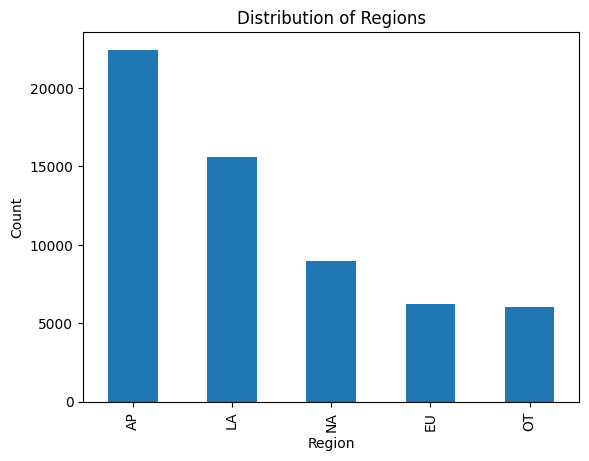

In [9]:
import matplotlib.pyplot as plt

train_process['region'].value_counts().plot(kind='bar')
plt.title('Distribution of Regions')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

In [10]:
# business_unit
train_process['business_unit']=train_process['business_unit'].replace('Solution','ETC')
train_process['business_unit']=train_process['business_unit'].replace('CM','ETC')

test_process['business_unit']=test_process['business_unit'].replace('Solution','ETC')
test_process['business_unit']=test_process['business_unit'].replace('CM','ETC')

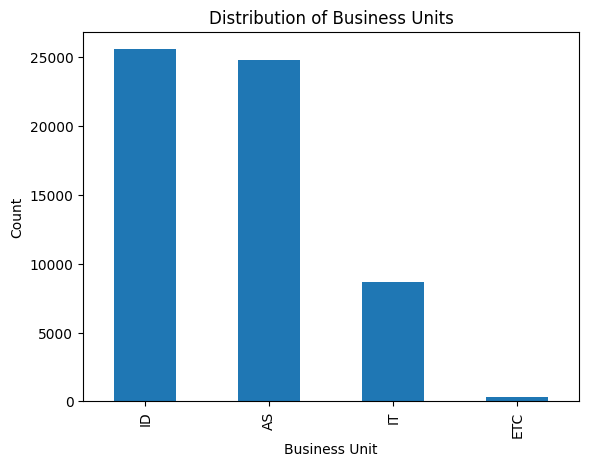

In [11]:
import matplotlib.pyplot as plt

train_process['business_unit'].value_counts().plot(kind='bar')
plt.title('Distribution of Business Units')
plt.xlabel('Business Unit')
plt.ylabel('Count')
plt.show()

In [12]:
# customer_type
def preprocess_customer_type(x,permitted):
    if type(x)==type(''):
        x=x.lower().replace('-','').replace(' ','')
        if permitted.get(x):
            return permitted[x]
        else:
            return 'OT'
    return x
    
train_process['customer_type']=train_process['customer_type'].apply(lambda x:preprocess_customer_type(x,permitted=permitted['customer_type']))
test_process['customer_type']=test_process['customer_type'].apply(lambda x:preprocess_customer_type(x,permitted=permitted['customer_type']))

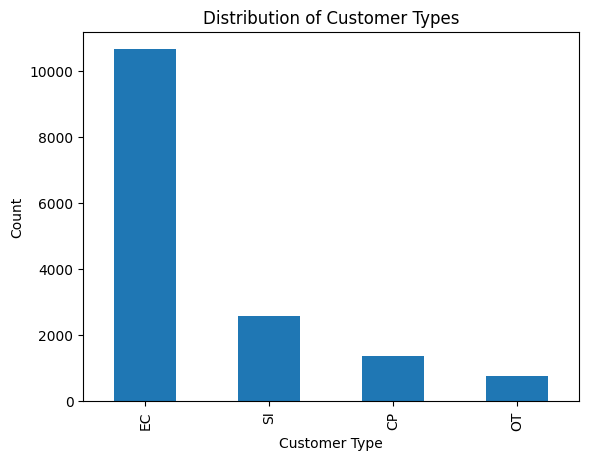

In [13]:
import matplotlib.pyplot as plt

train_process['customer_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Customer Types')
plt.xlabel('Customer Type')
plt.ylabel('Count')
plt.show()

In [14]:
# business_area(마지막2줄)
# total_data['business_area']=total_data['business_area'].replace('hospital & health care','ETC')
# total_data['business_area']=total_data['business_area'].replace('factory','ETC')
# total_data['business_area']=total_data['business_area'].replace('government department','ETC')
# total_data['business_area']=total_data['business_area'].replace('public facility','ETC')
# total_data['business_area']=total_data['business_area'].replace('transportation','ETC')
# total_data['business_area']=total_data['business_area'].replace('power plant / renewable energy','ETC')
train_process['business_area']=train_process['business_area'].fillna('UNK')
test_process['business_area']=test_process['business_area'].fillna('UNK')

In [15]:
# 'ver_cus' 열에서 '0'과 '1'의 개수를 각각 세기
count_0 = (train_process['ver_cus'] == 0).sum()
count_1 = (train_process['ver_cus'] == 1).sum()

print("0의 개수:", count_0)
print("1의 개수:", count_1)

0의 개수: 56832
1의 개수: 2467


In [16]:
# 'ver_pro' 열에서 '0'과 '1'의 개수를 각각 세기
count_0 = (train_process['ver_pro'] == 0).sum()
count_1 = (train_process['ver_pro'] == 1).sum()

print("0의 개수:", count_0)
print("1의 개수:", count_1)

0의 개수: 56286
1의 개수: 3013


In [17]:
# ver_cus, ver_pro
grant=['ver_cus', 'ver_pro']
train_process['grant_weight']=np.where(train_process['ver_cus']>0,1,0)
train_process['grant_weight']=np.where(train_process['ver_pro']>0,1,train_process['grant_weight'])
train_process=train_process.drop(grant,axis=1)

test_process['grant_weight']=np.where(test_process['ver_cus']>0,1,0)
test_process['grant_weight']=np.where(test_process['ver_pro']>0,1,test_process['grant_weight'])
test_process=test_process.drop(grant,axis=1)

In [18]:
# 'grant_weight' 열에서 '0'과 '1'의 개수를 각각 세기
count_0 = (train_process['grant_weight'] == 0).sum()
count_1 = (train_process['grant_weight'] == 1).sum()

print("0의 개수:", count_0)
print("1의 개수:", count_1)

0의 개수: 54639
1의 개수: 4660


In [19]:
# expected_timeline
def preprocess_expected_timeline(x,permitted):
    if type(x)==type(''):
        x=x.lower().replace(' ','').replace('_','')
        if permitted.get(x):
            return permitted[x]
        return 'OT'
    return x

train_process['expected_timeline']=train_process['expected_timeline'].apply(lambda x:preprocess_expected_timeline(x,permitted=permitted['expected_timeline']))
test_process['expected_timeline']=test_process['expected_timeline'].apply(lambda x:preprocess_expected_timeline(x,permitted=permitted['expected_timeline']))

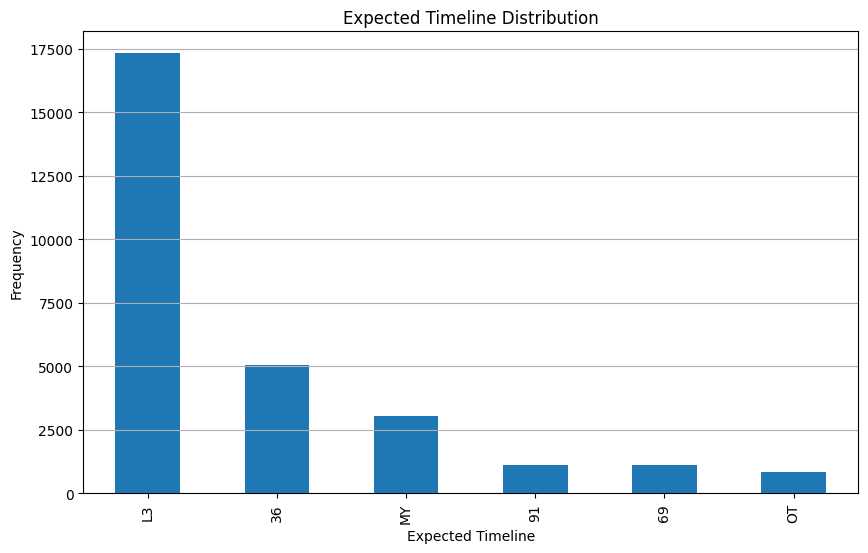

In [20]:
import matplotlib.pyplot as plt

# train 데이터의 'expected_timeline' 열에서 각 카테고리별 빈도 계산
train_expected_timeline_counts = train_process['expected_timeline'].value_counts()

# 막대 그래프 생성
plt.figure(figsize=(10, 6))
train_expected_timeline_counts.plot(kind='bar')
plt.title('Expected Timeline Distribution')
plt.xlabel('Expected Timeline')
plt.ylabel('Frequency')
plt.grid(axis='y')  # y축 그리드 표시
plt.show()

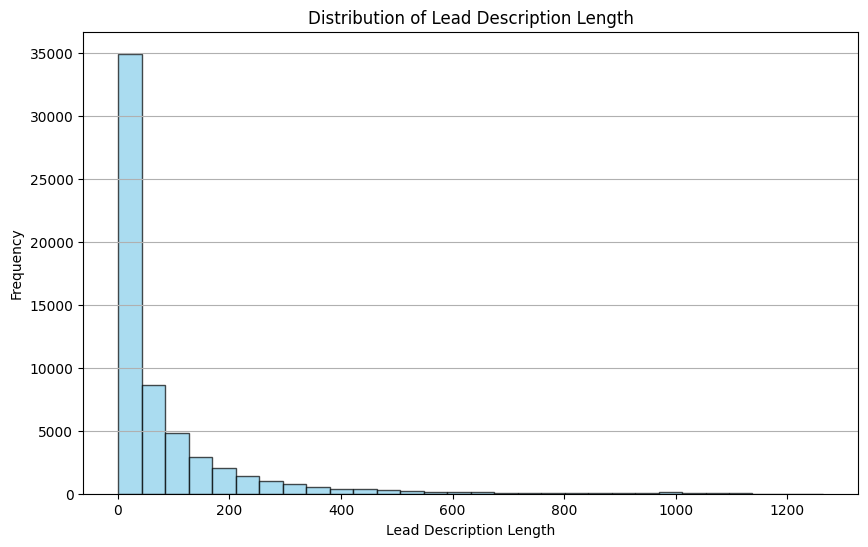

In [21]:
import matplotlib.pyplot as plt

# 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(train_process['lead_desc_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Lead Description Length')
plt.xlabel('Lead Description Length')
plt.ylabel('Frequency')
plt.grid(axis='y')  # y축 그리드 표시
plt.show()

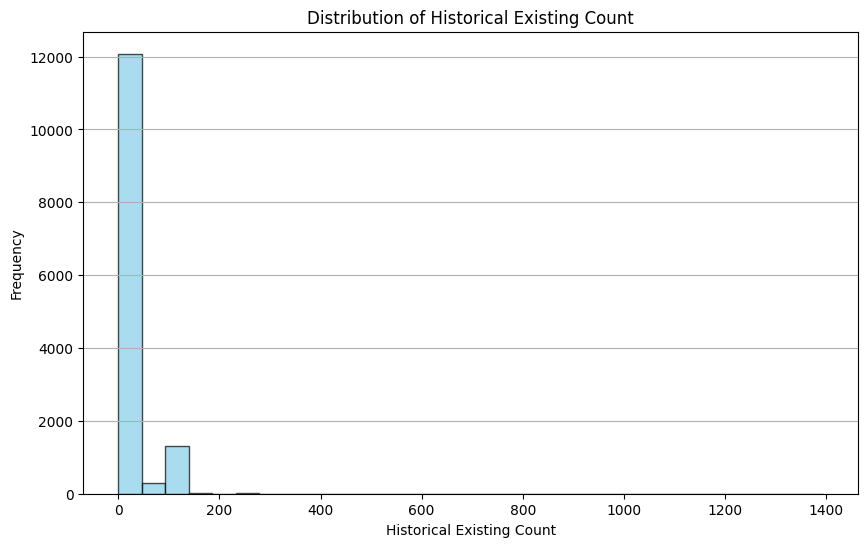

In [22]:
import matplotlib.pyplot as plt

# 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(train_process['historical_existing_cnt'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Historical Existing Count')
plt.xlabel('Historical Existing Count')
plt.ylabel('Frequency')
plt.grid(axis='y')  # y축 그리드 표시
plt.show()

In [23]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# lead_desc_length, historical_existing_cnt
numerical=['lead_desc_length','historical_existing_cnt']
#total_data[numerical]=scaler.fit_transform(total_data[numerical])
train_process[numerical]=np.log1p(train_process[numerical])
test_process[numerical]=np.log1p(test_process[numerical])

In [24]:
# inquiry_type
def preprocess_inquiry_type(x,permitted):
    if type(x)==type(''):
        x=x.lower().replace('_',' ')
        for word in x.split(' '):
            if permitted.get(word):
                return permitted[word]
        return 'OT'
    return np.nan

train_process['inquiry_type']=train_process['inquiry_type'].apply(lambda x:preprocess_inquiry_type(x,permitted=permitted['inquiry_type']))
test_process['inquiry_type']=test_process['inquiry_type'].apply(lambda x:preprocess_inquiry_type(x,permitted=permitted['inquiry_type']))

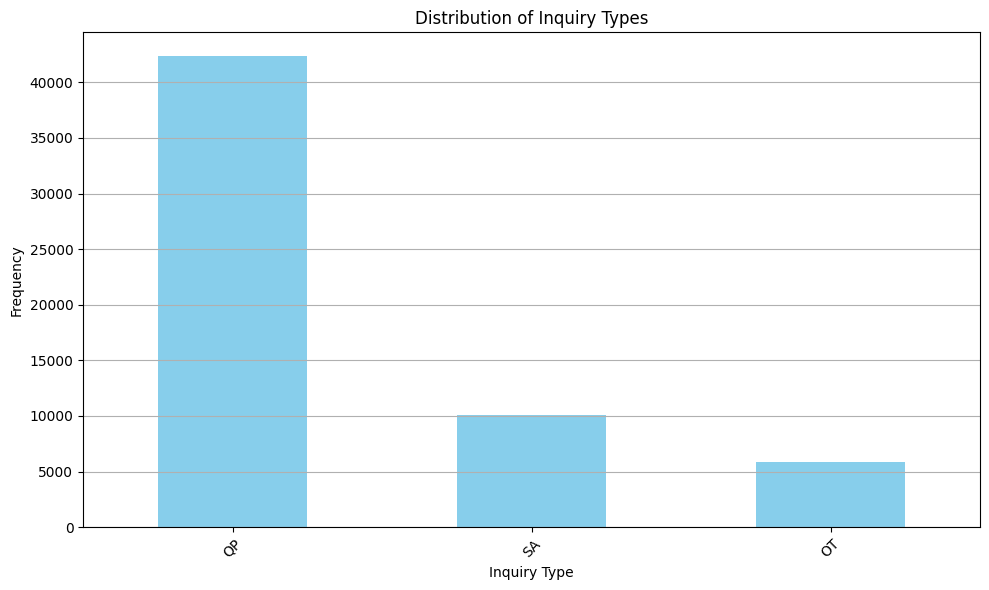

In [25]:
import matplotlib.pyplot as plt

# 'inquiry_type' 열의 값들에 대한 빈도 계산
inquiry_type_counts = train_process['inquiry_type'].value_counts()

# 막대 그래프 생성
plt.figure(figsize=(10, 6))
inquiry_type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Inquiry Types')
plt.xlabel('Inquiry Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # x축 라벨 회전
plt.grid(axis='y')  # y축 그리드 표시
plt.tight_layout()  # 그래프 간격 조정
plt.show()


In [26]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\happy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# PorterStemmer 객체 생성
porter = PorterStemmer()

# train 데이터에서 customer_job 컬럼 안의 데이터에서 어간 추출
all_words = []
for job in train_process['customer_job']:
    if isinstance(job, str):
        # 문장을 단어로 토큰화하여 어간 추출 후 리스트에 추가
        all_words.extend([porter.stem(word) for word in word_tokenize(job)])

# 어간 빈도 계산
word_freq = Counter(all_words)

# 가장 많은 빈도를 보이는 상위 15개의 어간 추출
top_10_words_customer_job = [word for word, _ in word_freq.most_common(15)]

print("customer_job 상위 15개 어간:")
for word in top_10_words_customer_job:
    print(word)

customer_job 상위 15개 어간:
engin
other
administr
and
educ
sale
oper
purchas
technolog
inform
art
develop
busi
manag
consult


In [28]:
# customer_job
def preprocess_customer_job(x,permitted):
    if type(x)==type(''):
        porter=PorterStemmer()
        tokens=word_tokenize(x)
        stems=[porter.stem(token) for token in tokens]
        for stem in stems:
            if permitted.get(stem):
                return permitted[stem]
        return 'OT'
    return np.nan

train_process['customer_job']=train_process['customer_job'].apply(lambda x:preprocess_customer_job(x,permitted=permitted['customer_job']))
test_process['customer_job']=test_process['customer_job'].apply(lambda x:preprocess_customer_job(x,permitted=permitted['customer_job']))

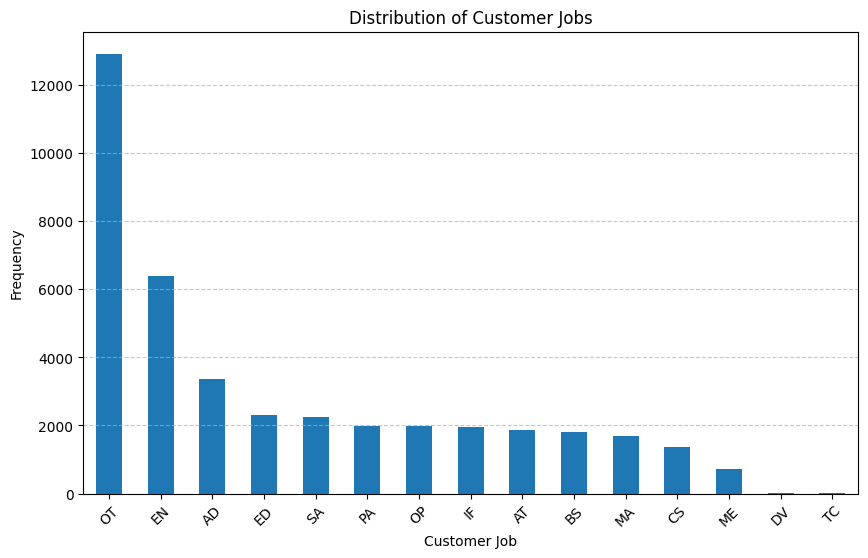

In [29]:
import matplotlib.pyplot as plt

# customer_job 열의 값별 빈도수 계산
customer_job_counts = train_process['customer_job'].value_counts()

# 그래프 그리기
plt.figure(figsize=(10, 6))
customer_job_counts.plot(kind='bar')
plt.title('Distribution of Customer Jobs')
plt.xlabel('Customer Job')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# PorterStemmer 객체 생성
porter = PorterStemmer()

# train 데이터에서 product_category 컬럼 안의 데이터에서 어간 추출
all_words = []
for product in train_process['product_category']:
    if isinstance(product, str):
        # 문장을 단어로 토큰화하여 어간 추출 후 리스트에 추가
        all_words.extend([porter.stem(word) for word in word_tokenize(product)])

# 어간 빈도 계산
word_freq = Counter(all_words)

# 가장 많은 빈도를 보이는 상위 15개의 어간 추출
top_10_words_product_category = [word for word, _ in word_freq.most_common(15)]

print("product_category 상위 15개 어간:")
for word in top_10_words_product_category:
    print(word)

product_category 상위 15개 어간:
signag
interact
digit
board
vrf
multi-split
video
wall
.
etc
led
single-split
tv
:
seri


In [31]:
# product_category
def preprocess_product_category(x,permitted):
    if type(x)==type(''):
        porter=PorterStemmer()
        tokens=word_tokenize(x)
        stems=[porter.stem(token) for token in tokens]

        prefer={}
        for pf in permitted['dump_key']:
            prefer[pf]=0
        
        for stem in stems:
            if permitted.get(stem):
                prefer[permitted[stem]]=1

        for pf in permitted['dump_key']:
            if prefer[pf]>0:
                return pf
        return 'OT'
    return np.nan

train_process['product_category']=train_process['product_category'].apply(lambda x:preprocess_product_category(x,permitted=permitted['product_category']))
test_process['product_category']=test_process['product_category'].apply(lambda x:preprocess_product_category(x,permitted=permitted['product_category']))

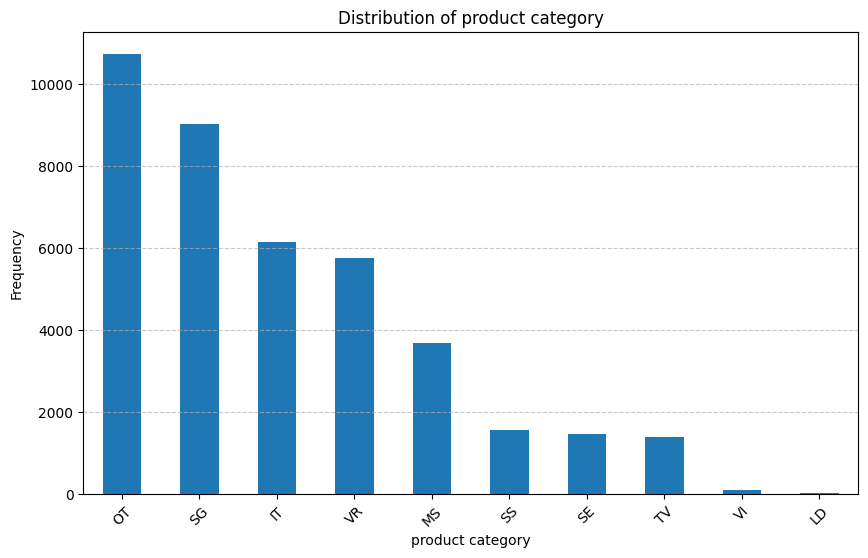

In [32]:
import matplotlib.pyplot as plt

# product_category 열의 값별 빈도수 계산
product_category_counts = train_process['product_category'].value_counts()

# 그래프 그리기
plt.figure(figsize=(10, 6))
product_category_counts.plot(kind='bar')
plt.title('Distribution of product category')
plt.xlabel('product category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [33]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# PorterStemmer 객체 생성
porter = PorterStemmer()

# train 데이터에서 customer_position 컬럼 안의 데이터에서 어간 추출
all_words = []
for position in train_process['customer_position']:
    if isinstance(position, str):
        # 문장을 단어로 토큰화하여 어간 추출 후 리스트에 추가
        all_words.extend([porter.stem(word) for word in word_tokenize(position)])

# 어간 빈도 계산
word_freq = Counter(all_words)

# 가장 많은 빈도를 보이는 상위 15개의 어간 추출
top_10_words_customer_position = [word for word, _ in word_freq.most_common(15)]

print("customer_position 상위 15개 어간:")
for word in top_10_words_customer_position:
    print(word)

customer_position 상위 15개 어간:
none
manag
ceo/found
other
director
associate/analyst
partner
entri
level
execut
c-level
traine
presid
vice
intern


In [34]:
# customer_position
def preprocess_customer_position(x,permitted):
    if type(x)==type(''):
        x=x.lower().replace('-',' ').replace('/',' ')
        for word in x.split(' '):
            if permitted.get(word):
                return permitted[word]
        return 'OT'
    return np.nan

train_process['customer_position']=train_process['customer_position'].apply(lambda x:preprocess_customer_position(x,permitted=permitted['customer_position']))
test_process['customer_position']=test_process['customer_position'].apply(lambda x:preprocess_customer_position(x,permitted=permitted['customer_position']))

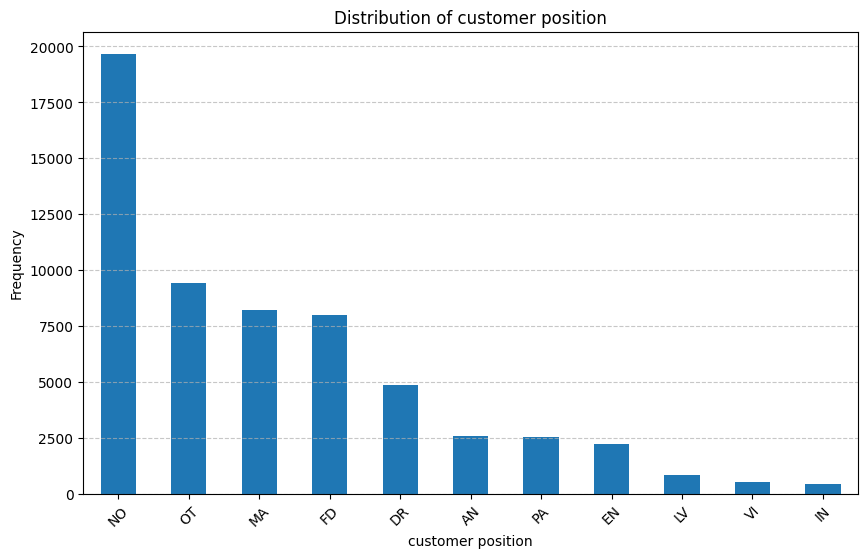

In [35]:
import matplotlib.pyplot as plt

# customer_position 열의 값별 빈도수 계산
customer_position_counts = train_process['customer_position'].value_counts()

# 그래프 그리기
plt.figure(figsize=(10, 6))
customer_position_counts.plot(kind='bar')
plt.title('Distribution of customer position')
plt.xlabel('customer position')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [123]:
# one hot encoding columns
origin_data=train_process.drop('com_reg_ver_win_rate',axis=1)
origin_columns=origin_data.columns.to_list()
object_columns=origin_data.columns.to_list()
object_columns.remove('bant_submit')
object_columns.remove('historical_existing_cnt')
object_columns.remove('lead_desc_length')
object_columns.remove('strategic_ver')
object_columns.remove('grant_weight')
object_columns.remove('customer_idx')
object_columns.remove('lead_owner')
for col in object_columns:
    permitted['values'][col]=train_process[col].value_counts().index
permitted['values']

{'customer_country': Index(['india', 'brazil', 'unitedstates', 'OT', 'mexico', 'philippines',
        'colombia', 'u.a.e', 'unitedkingdom', 'saudiarabia', 'chile', 'italy',
        'peru', 'germany', 'poland', 'egypt', 'vietnam', 'spain', 'argentina',
        'hongkong', 'australia', 'panama', 'france', 'canada', 'turkey',
        'ecuador', 'indonesia', 'türkiye', 'singapore', 'southafrica', 'iraq',
        'nigeria', 'thailand', 'hungary', 'portugal', 'kenya', 'malaysia',
        'bulgaria', 'costarica', 'dominicanrepublic', 'israel', 'oman',
        'elsalvador', 'pakistan', 'guatemala', 'kuwait', 'bangladesh', 'qatar',
        'switzerland', 'china', 'bolivia', 'honduras', 'lebanon', 'taiwan',
        'netherlands', 'belgium', 'bahrain', 'venezuela', 'puertorico',
        'greece', 'japan', 'afghanistan', 'algeria', 'morocco', 'romania',
        'ghana', 'jordan', 'croatia', 'nicaragua', 'ireland', 'maldives',
        'serbia', 'srilanka', 'uruguay', 'albania', 'jamaica', 'southkor

In [124]:
# encoder
class Encoder():
    def __init__(self):
        self.classes=[]

    def fit(self,data):
        for value in data.value_counts().index:
            self.classes.append(value)

    def transform(self,data):
        result=data.copy(deep=True)
        for i,value in enumerate(self.classes):
            result=result.replace(value,i)
        return result
    
    def inverse_transform(self,data):
        result=data.copy(deep=True)
        for i in range(0,len(self.classes)):
            result=result.replace(i,self.classes[i])
        return result

In [125]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

imputer=IterativeImputer(estimator=RandomForestRegressor(random_state=SEED),initial_strategy='most_frequent',max_iter=10,random_state=SEED,skip_complete=False,verbose=1)

# encoder
encoders={}
for object_column in object_columns:
    encoders[object_column]=Encoder()
    encoders[object_column].fit(train_process[object_column])


def order_encoding(target_data,object_columns,encoders):
    result=pd.DataFrame()
    for col in target_data.columns:
        if col in object_columns:
            result[col]=encoders[col].transform(target_data[col])
        else:
            result[col]=target_data[col]

    return result

def order_decoding(target_data,object_columns,encoders):
    result=pd.DataFrame()
    for col in target_data.columns:
        if col in object_columns:
            result[col]=target_data[col].apply(lambda x:round(x)).astype(int)
            result[col]=encoders[col].inverse_transform(result[col])
        else:
            result[col]=target_data[col]
    return result

# train data
train_dummy=order_encoding(train_process,object_columns,encoders)
imputer.fit(train_dummy)  
train_dummy_imputed=pd.DataFrame(data=imputer.transform(train_dummy),columns=train_process.columns)
train_imputed=order_decoding(train_dummy_imputed,object_columns,encoders)

# test data
test_dummy=order_encoding(test_process,object_columns,encoders)
test_dummy_imputed=pd.DataFrame(data=imputer.transform(test_dummy),columns=test_process.columns)
test_imputed=order_decoding(test_dummy_imputed,object_columns,encoders)


[IterativeImputer] Completing matrix with shape (59299, 20)
[IterativeImputer] Change: 80.28782576841168, scaled tolerance: 47.466 
[IterativeImputer] Change: 31.937348819464514, scaled tolerance: 47.466 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (59299, 20)
[IterativeImputer] Completing matrix with shape (5271, 20)


In [126]:
# data kfold
from sklearn.model_selection import KFold

train_datas=[]
train_imputed['is_converted']=targets
train_data_false=train_imputed[train_imputed['is_converted']==0]
train_data_true=train_imputed[train_imputed['is_converted']==1]

# kfold
K=11
dkf=KFold(n_splits=K,shuffle=True,random_state=SEED)
preserves=[pd.DataFrame() for x in range(0,K+1)]
for i,(_,index) in enumerate(dkf.split(train_data_false)):
    print(f'-{i+1} fold data-')
    y_data_false=train_data_false['is_converted'].iloc[index]
    X_data_false=train_data_false.drop('is_converted',axis=1).iloc[index]
    
    y_data=pd.concat([y_data_false,train_data_true['is_converted']],ignore_index=True)
    X_data=pd.concat([X_data_false,train_data_true.drop('is_converted',axis=1)],ignore_index=True)

    # preserve
    # preserves[i]['com_reg_ver_win_rate']=X_data['com_reg_ver_win_rate']
    # X_data=X_data.drop('com_reg_ver_win_rate',axis=1)
    # preserves[i]['customer_idx']=X_data['customer_idx']
    # X_data['customer_idx']=np.log1p(X_data['customer_idx'])
    # preserves[i]['lead_owner']=X_data['lead_owner']
    # X_data['lead_owner']=np.log1p(X_data['lead_owner'])
    

    print(f'X data shape: {X_data.shape}')
    print(f'y data shape: {y_data.shape}')
    train_datas.append((X_data,y_data))

# preserve
# preserves[K]['com_reg_ver_win_rate']=test_process['com_reg_ver_win_rate']
# test_data=test_process.drop('com_reg_ver_win_rate',axis=1)
# preserves[K]['customer_idx']=X_data['customer_idx']
# test_data['customer_idx']=np.log1p(test_data['customer_idx'])
# preserves[K]['lead_owner']=X_data['lead_owner']
# test_data['lead_owner']=np.log1p(test_data['lead_owner'])
test_data=test_imputed
print(f'test data shape: {test_data.shape}')

-1 fold data-
X data shape: (9800, 20)
y data shape: (9800,)
-2 fold data-
X data shape: (9800, 20)
y data shape: (9800,)
-3 fold data-
X data shape: (9800, 20)
y data shape: (9800,)
-4 fold data-
X data shape: (9800, 20)
y data shape: (9800,)
-5 fold data-
X data shape: (9800, 20)
y data shape: (9800,)
-6 fold data-
X data shape: (9800, 20)
y data shape: (9800,)
-7 fold data-
X data shape: (9800, 20)
y data shape: (9800,)
-8 fold data-
X data shape: (9800, 20)
y data shape: (9800,)
-9 fold data-
X data shape: (9800, 20)
y data shape: (9800,)
-10 fold data-
X data shape: (9800, 20)
y data shape: (9800,)
-11 fold data-
X data shape: (9799, 20)
y data shape: (9799,)
test data shape: (5271, 20)


In [127]:
# process data type
for (train_data,target) in train_datas:
    train_data['customer_idx']=train_data['customer_idx'].astype(str)
    train_data['lead_owner']=train_data['lead_owner'].astype(str)
    train_data['strategic_ver']=train_data['strategic_ver'].astype(int)
    train_data['grant_weight']=train_data['grant_weight'].astype(int)
    target=target.apply(lambda x:1 if x else 0)

test_data['customer_idx']=test_data['customer_idx'].astype(str)
test_data['lead_owner']=test_data['lead_owner'].astype(str)
test_data['strategic_ver']=test_data['strategic_ver'].astype(int)
test_data['grant_weight']=test_data['grant_weight'].astype(int)

In [128]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics         import mean_squared_error

In [129]:
# 모델 성능 테스트
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))
    return F1

In [130]:
class KMODEL:
    def __init__(self,dataset_K,train_K=5):
        self.k_data=dataset_K
        self.k_fold=train_K
        self.models=[[] for i in range(0,K)]
        self.scores=[[] for i in range(0,K)]
        self.thresholds=[[] for i in range(0,K)]
        self.cv_scores=[]

    def modeling_kfold(self,iters,n_estimators,max_depth,learning_rate,cat_features,train_data,targets_data,core):
        # k-fold
        kf=StratifiedKFold(n_splits=self.k_fold,shuffle=True,random_state=SEED)

        for i,(train_index,val_index) in enumerate(kf.split(train_data,targets_data)):
            print(f'-[{iters+1}-{i+1}] fold-')
            X_train,X_val=train_data.iloc[train_index],train_data.iloc[val_index]
            y_train,y_val=targets_data.iloc[train_index],targets_data.iloc[val_index]

            # logloss
            classifier=CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, eval_metric='F1', random_state=SEED, bootstrap_type ='Bernoulli',task_type=core) # default:logloss
            
            # randomforst
            #classifier=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,random_state=SEED)

            # regressor=CatBoostRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, eval_metric='RMSE',random_state=SEED, bootstrap_type ='Bernoulli',task_type=core)

            model=classifier.fit(X_train, y_train, eval_set=(X_val,y_val),verbose=100, early_stopping_rounds=100,cat_features=cat_features,use_best_model=True)
            #model=classifier.fit(X_train,y_train)
            # model=regressor.fit(X_train, y_train, eval_set=(X_val,y_val),verbose=100, early_stopping_rounds=100,cat_features=cat_features)
            
            
            # pred=model.predict(X_val,prediction_type='RawFormulaVal')  # focal loss
            # coordinates=np.linspace(pred.min(),pred.max(),100)   # focal loss
            pred=model.predict_proba(X_val)[:,1]
            coordinates = np.linspace(0, 1, 100)

            best_score=0
            best_coordinate=0
            for coordinate in coordinates:
                pred_value=pred>coordinate
                score=f1_score(y_val,pred_value)
                if best_score<score:
                    best_score=score
                    best_coordinate=coordinate
            
            pred=(pred>best_coordinate)
            self.scores[iters].append(get_clf_eval(y_val,pred))
            self.thresholds[iters].append(best_coordinate)
            # scores.append(np.sqrt(mean_squared_error(y_val,pred)))
            self.models[iters].append(model)
        
        self.cv_scores.append(np.mean(self.scores[iters]))
        print(f'[{iters+1}] F1 scores mean: {self.cv_scores[iters]}')

    def modeling_kdata(self,n_estimators,max_depth,learning_rate,cat_features,train_datas,core='CPU'):
        for iter,(train_data,target) in enumerate(train_datas):
            self.modeling_kfold(iter,n_estimators,max_depth,learning_rate,cat_features,train_data,target,core=core)
        print(f'Total F1 scores mean: {np.mean(self.cv_scores)}')

    def predict(self,test_data):
        test_pred=pd.Series([0 for x in range(len(test_data))], index=test_data.index)
        for models,thresholds in zip(self.models,self.thresholds):
            for model,threshold in zip(models,thresholds):
                pred=model.predict_proba(test_data)[:,1]
                test_pred+=(pred>threshold)
        test_pred=test_pred/(self.k_data*self.k_fold)
        test_pred=test_pred.apply(lambda x:1 if x>0.5 else 0)
        return test_pred



In [131]:
cat_features=train_datas[0][0].columns.to_list()
cat_features.remove('bant_submit')
cat_features.remove('lead_desc_length')
cat_features.remove('historical_existing_cnt')
cat_features.remove('com_reg_ver_win_rate')
cat_features

['customer_country',
 'business_unit',
 'customer_idx',
 'customer_type',
 'enterprise',
 'customer_job',
 'inquiry_type',
 'product_category',
 'customer_position',
 'response_corporate',
 'expected_timeline',
 'business_area',
 'lead_owner',
 'strategic_ver',
 'region',
 'grant_weight']

In [132]:
kmodel=KMODEL(dataset_K=11)
kmodel.modeling_kdata(n_estimators=1000,max_depth=10,learning_rate=0.05,cat_features=cat_features,train_datas=train_datas)

-[1-1] fold-
0:	learn: 0.8439847	test: 0.8541973	best: 0.8541973 (0)	total: 168ms	remaining: 2m 48s
100:	learn: 0.9608094	test: 0.9267548	best: 0.9289340 (84)	total: 19.3s	remaining: 2m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9289340102
bestIteration = 84

Shrink model to first 85 iterations.
오차행렬:
 [[915  55]
 [ 86 904]]

정확도: 0.9281
정밀도: 0.9141
재현율: 0.9433
F1: 0.9285
-[1-2] fold-
0:	learn: 0.8378745	test: 0.8715686	best: 0.8715686 (0)	total: 156ms	remaining: 2m 35s
100:	learn: 0.9607088	test: 0.9396728	best: 0.9410559 (85)	total: 18.7s	remaining: 2m 46s
200:	learn: 0.9813265	test: 0.9390056	best: 0.9421403 (117)	total: 37.6s	remaining: 2m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.942140297
bestIteration = 117

Shrink model to first 118 iterations.
오차행렬:
 [[923  47]
 [ 66 924]]

정확도: 0.9423
정밀도: 0.9333
재현율: 0.9515
F1: 0.9423
-[1-3] fold-
0:	learn: 0.8449466	test: 0.8450128	best: 0.8450128 (0)	total: 139ms	remaining: 2m 18

In [133]:
pred=kmodel.predict(test_data)
pred.value_counts()

0    3612
1    1659
dtype: int64